### Example 4 - Map of Argo and GLODAP temperature measurements in the South Eastern Indian Ocean (Poseidon version)

This example will show you how to read and manipulate both Argo and GLODAP temperature data stored in parquet format in WHOI's AWS S3 data lake.

The data are stored across multiple files: we will load into memory only what we need by applying some filters, and we will create a map showing the chlorophyll content in the North West Atlantic.

##### Note on AWS S3

In this example we will access metadata stored in WHOI's **AWS S3** data lake. Reading data from WHOI's Poseidon cluster is slightly different and we refer you to dedicated examples (manipulating the data once loaded into the memory does not change).

NB: Access to the data lake should be public at this time. If you get some permission error, [reach out](enrico.milanese@whoi.edu).

##### Note on parquet files

The original netCDF Argo and GLODAP files have been converted to parquet format, which provides faster read operations.

There are a couple of ways to read parquet files in Python. We will use pyarrow to load the dataset, so that we can provide a target schema (containing the Argo variable names) and load the data consistently across floats, independently of what variables each float actually has. We will finally convert the dataset to a pandas dataframe for manipulation and plots.
Other ways to read parquet files are by using pandas (make sure you have pyarrow, fastparquet or some other suitable engine installed), and Dask. Generally speaking, you'll want to use Dask only if you need a large amount of data at the same time so that you can benefit from its parallelization. You should avoid Dask whenever the data fits in your RAM.

When reading parquet files with pyarrow (or pandas), you can either specificy the file name(s), or the directory containing all the parquet files. In latter case if you apply any filter, pandas and pyarrow will sort through all the files in the folder, reading into memory only the subsets that satisfy your filter.

#### Getting started

We start by importing the necessary modules and setting the path and filenames of the parquet files.  For a list of modules that you need to install, you can look at the [README.md file in the repository](https://github.com/boom-lab/nc2parquet).

We also set up the unified schema that pyarrow will need to read the parquet files. This is needed because not all parquet files contain the same variables, depending on what variables are contained in the Argo floats inside each file. This reduces the number of empty fields, and in turn the memory usage during the conversion of the Argo mirror to the parquet format. If we didn't provide the unified schema, pyarrow would not read all the data.

Finally, we declare the geographical coordinates that the limit the area that we are interested in (South Eastern Indian Ocean).

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from pprint import pprint

# Importing AWS S3 modules, setting AWS S3 paths and file system
from pyarrow import fs
import boto3
from botocore import UNSIGNED
from botocore.client import Config
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED), region_name='us-east-1')

paginator = s3.get_paginator('list_objects_v2')
pages_pqt = paginator.paginate(
    Bucket='argo-experimental',
    Prefix='pqt/data/')

aws_path ='s3://argo-experimental/'
argo_files_aws = []
glodap_files_aws = []
for page in pages_pqt:
    for content in page['Contents']:
        if 'PHY' in content['Key'] and content['Key'].endswith('.parquet'):
            argo_files_aws.append(aws_path + content['Key'])
        elif 'GLODAP' in content['Key'] and content['Key'].endswith('.parquet'):
            glodap_files_aws.append(aws_path + content['Key'])

paginator = s3.get_paginator('list_objects_v2')
pages_meta = paginator.paginate(
    Bucket='argo-experimental',
    Prefix='pqt/data/metadata/' 
)

aws_path ='s3://argo-experimental/'
argo_meta_aws = []
glodap_meta_aws = []
for page in pages_meta:
    for content in page['Contents']:
        if 'PHY' in content['Key']:
            argo_meta_aws.append(aws_path + content['Key'])
        if 'GLODAP' in content['Key']:
            glodap_meta_aws.append(aws_path + content['Key'])
argo_pa_files = [pqt_file.strip("s3://") for pqt_file in argo_files_aws]
glodap_pa_files = [pqt_file.strip("s3://") for pqt_file in glodap_files_aws]

if len(argo_meta_aws)>1:
    raise("Error: cannot read parquet schema, multiple files provided")
PHY_schema = pq.read_schema(argo_meta_aws[0])

if len(glodap_meta_aws)>1:
    raise("Error: cannot read parquet schema, multiple files provided")
GLODAP_schema = pq.read_schema(glodap_meta_aws[0])

fs, _ = fs.FileSystem.from_uri(argo_files_aws[0])

# We import argopy only for speed comparisons
import argopy
argopy.reset_options()

lat0 = -60
lat1 = 0
lon0 = 70
lon1 = 130

We first query the parquet files for the variable names, as we might not be familiar with them, or we might want to make sure that indeed the names have not been changed from the Argo convention. We do the same in the next cell for GLODAP's database: note that at the moment only a few variables have been adapted to match Argo's nomenclature. Future work includes homogeneizing the nomenclature across datasets.

### Separate read

We first load the two datasets separately.

#### Timing test

The geographical coordinates are stored in the variables 'LATITUDE'and 'LONGITUDE'. We then generate the filter, with its syntax being: `[[(column, op, val), …],…]` where `column` is the variable name, and `val` is the value to for the operator `op`, which accepts `[==, =, >, >=, <, <=, !=, in, not in]`. Similarly, we will also filter by depth through the pressure values in 'PRES_ADJUSTED', to restrain our selection to the first 50m of the ocean.

Let's set up the filters first:

In [2]:
ref_var = 'TEMP_ADJUSTED'
cols = [ref_var,"LATITUDE","LONGITUDE","PRES_ADJUSTED"]
filter_coords_pres = [("LATITUDE",">",lat0), ("LATITUDE","<",lat1),
                           ("LONGITUDE",">",lon0), ("LONGITUDE","<",lon1),
                           ("PRES_ADJUSTED",">=",0),("PRES_ADJUSTED","<=",50),
                           (ref_var,">=",-1e30),(ref_var,"<=",+1e30)]

Now we time how long it takes to load the filtered datasets separately:

In [3]:
%%time
argo_ds = pq.ParquetDataset(
    argo_pa_files,
    filesystem=fs, 
    schema=PHY_schema, 
    filters=filter_coords_pres
)
argo_df = argo_ds.read(columns=cols).to_pandas()

CPU times: user 51.1 s, sys: 32.9 s, total: 1min 23s
Wall time: 3min 4s


In [4]:
%%time
glodap_ds = pq.ParquetDataset(
    glodap_pa_files,
    filesystem=fs, 
    schema=GLODAP_schema, 
    filters=filter_coords_pres
)
glodap_df = glodap_ds.read(columns=cols).to_pandas()

CPU times: user 89.1 ms, sys: 89.4 ms, total: 178 ms
Wall time: 1.09 s


It should have taken a total wall time of around 1min 30s seconds for the Argo dataset, and some milliseconds for the GLODAP dataset (the in-disk memory of the latter is much smaller, roughly 90 MB vs 13 GB). If you explore the dataframes, you will see that they contain the same variables, and that Argo `argo_df` has around 4.6 million rows, and `glodap_df` around 5,000.

In [5]:
argo_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,11.058,-42.39233,70.03837,1.160000
1,11.058,-42.39233,70.03837,2.040000
2,11.059,-42.39233,70.03837,2.920000
3,11.057,-42.39233,70.03837,4.040000
4,11.055,-42.39233,70.03837,5.040000
...,...,...,...,...
3780561,14.124,-37.59205,75.55071,40.000000
3780562,14.123,-37.59205,75.55071,42.040001
3780563,14.123,-37.59205,75.55071,43.959999
3780564,14.123,-37.59205,75.55071,45.919998


In [6]:
glodap_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,1.7251,-57.9070,82.9600,9.0
1,1.7223,-57.9070,82.9600,9.0
2,1.7219,-57.9070,82.9600,9.0
3,1.9701,-57.7790,83.2190,10.0
4,1.9687,-57.7790,83.2190,11.0
...,...,...,...,...
5321,26.7716,-20.0001,80.0002,11.0
5322,26.8346,-20.4961,79.9998,1.0
5323,26.8346,-20.4961,79.9998,1.0
5324,26.8081,-20.4961,79.9998,10.0


#### Maps

We now plot the temperature measurements, averaged along the selected depth. We did not set any condition on the time, so all measurements are plotted (caveat: as we group the measurements by geographical coordinates, if two or more measurements taken at different times share the same location, the temperature value is averaged across those measurements). In this first map, we will use two separate color maps for the two dataframes, to display their contributions.

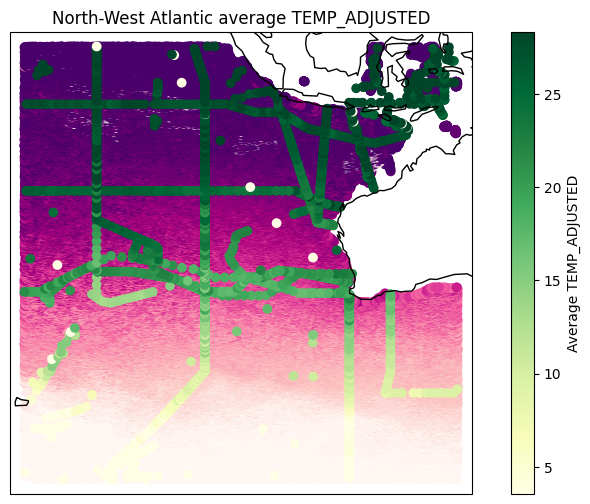

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED'
argo_grouped = argo_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

glodap_grouped = glodap_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = argo_df[ref_var].quantile(q=0.1)
cbar_max = argo_df[ref_var].quantile(q=0.9)
plt.scatter(argo_grouped['LONGITUDE'], argo_grouped['LATITUDE'], c=argo_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='RdPu', transform=ccrs.PlateCarree())
plt.scatter(glodap_grouped['LONGITUDE'], glodap_grouped['LATITUDE'], c=glodap_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='YlGn', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([lon0-2, lon1+2])
plt.ylim([lat0-2, lat1+2])
plt.show()

### Concurrent read

We now want to read both datasets at once, we can do this by providing one list of parquet files and a unified schema. We could also provide a directory if all files were contained there, but at the moment our data lake stores the different databases in separate folders.

In [8]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from pprint import pprint

pqt_files_aws = argo_pa_files.copy()
pqt_files_aws.extend(glodap_pa_files)

# Setting up parquet schema
combined_schema = pa.unify_schemas([PHY_schema, GLODAP_schema], promote_options="permissive")

#### Timing

We can now load the two datasets into a combined dataframe.

In [9]:
%%time

combined_ds = pq.ParquetDataset(
    pqt_files_aws,
    filesystem=fs, 
    schema=combined_schema, 
    filters=filter_coords_pres
)
combined_df = combined_ds.read(columns=cols).to_pandas()

CPU times: user 53.7 s, sys: 37.8 s, total: 1min 31s
Wall time: 2min 48s


This took slightly than we loaded them separately (8 seconds vs 4 seconds), probably because the combined schema has many more variables that each original parquet files. Concatenating the dataframes that we loaded separately earlier is really fast instead, so we might decide to implement a mask that does this behind scenes.

In [10]:
combined_df

,TEMP_ADJUSTED,LATITUDE,LONGITUDE,PRES_ADJUSTED
0,11.0580,-42.39233,70.03837,1.16
1,11.0580,-42.39233,70.03837,2.04
2,11.0590,-42.39233,70.03837,2.92
3,11.0570,-42.39233,70.03837,4.04
4,11.0550,-42.39233,70.03837,5.04
...,...,...,...,...
3785887,26.7716,-20.00010,80.00020,11.00
3785888,26.8346,-20.49610,79.99980,1.00
3785889,26.8346,-20.49610,79.99980,1.00
3785890,26.8081,-20.49610,79.99980,10.00


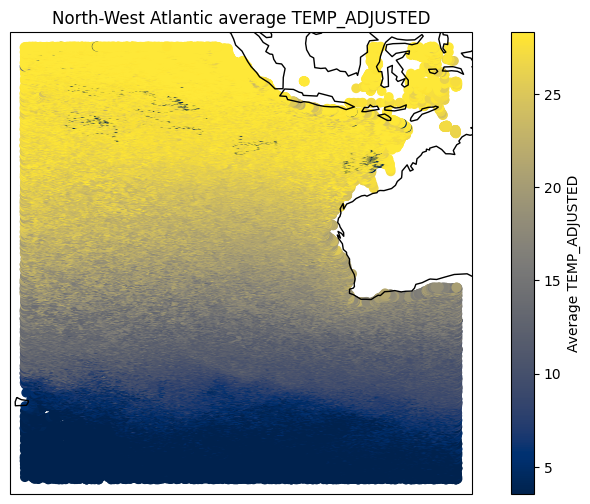

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colormaps

# Group by 'LATITUDE' and 'LONGITUDE', and aggregate by averaging over 'PRES_ADJUSTED'
combined_grouped = combined_df.groupby(['LATITUDE', 'LONGITUDE']).agg({
    'PRES_ADJUSTED': 'mean',  # Take the mean depth
    ref_var: 'mean'  # Take the mean intensity
}).reset_index()

# Plotting using Cartopy
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot
cbar_min = combined_df[ref_var].quantile(q=0.1)
cbar_max = combined_df[ref_var].quantile(q=0.9)
plt.scatter(combined_grouped['LONGITUDE'], combined_grouped['LATITUDE'], c=combined_grouped[ref_var], vmin=cbar_min, vmax=cbar_max, cmap='cividis', transform=ccrs.PlateCarree())
plt.colorbar(label='Average ' + ref_var)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North-West Atlantic average ' + ref_var)
plt.grid(True)
plt.xlim([lon0-2, lon1+2])
plt.ylim([lat0-2, lat1+2])
plt.show()